In [2]:
from keypress_recognition.models import black_key_model as bmodel
from keypress_recognition import dataset_p as dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [5]:
dataset.load_all_data(color=['black'], size=['single'], keypress=True)

Start seperating keyboard ...
  White single width: 21px
  Black single width: 20px
  White bundle width: 37px
  Black bundle width: 36px


IntProgress(value=0, max=14273)

In trainset: 
  # of pressed black key: 8755
  # of unpressed black key: 43840


IntProgress(value=0, max=5000)

In testset: 
  # of pressed black key: 761
  # of unpressed black key: 22588


IntProgress(value=0, max=2993)

In valset: 
  # of pressed black key: 817
  # of unpressed black key: 10867


In [6]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Pressed" if note else "Not Pressed")
visualize_keys(True)

'Pressed'

Samples from X_train: 


IntProgress(value=0, max=87680)

(2, 106, 20, 3)
1 0
Samples from X_test: 


IntProgress(value=0, max=45176)

(2, 106, 20, 3)
1 0
Samples from X_val: 


IntProgress(value=0, max=21734)

(2, 106, 20, 3)
1 0


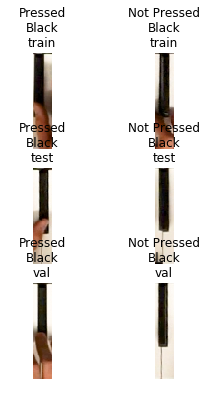

In [7]:
# print several images with labels
fig, axarr = plt.subplots(3, 2, figsize=[4, 6])
for ii, _type in enumerate(['train', 'test', 'val']):

    print(f'Samples from X_{_type}: ')

    for imgb, noteb in dataset.data_batch(type=_type, size='single', color='black', batch_size=2, NCHW=False, need_velocity=False):
        print(imgb.shape)
        print(noteb[0], noteb[1])
        axarr[ii,0].imshow(cv2.cvtColor(imgb[0], cv2.COLOR_BGR2RGB))
        axarr[ii,0].set_title(visualize_keys(noteb[0]) + '\nBlack\n' + _type)
        axarr[ii,0].axis('off')
        axarr[ii,1].imshow(cv2.cvtColor(imgb[1], cv2.COLOR_BGR2RGB))
        axarr[ii,1].set_title(visualize_keys(noteb[1]) + '\nBlack\n' + _type)
        axarr[ii,1].axis('off')
        break

plt.show()

In [ ]:
bmodel.train(dataset, batch_size=32, size='single', color='black',
             num_epochs=10,
             max_num=100,
             learning_rate=1e-4,
             best_path='keypress_recognition/best_black_model.tar',
             current_path='keypress_recognition/current_black.tar',
             method=0)

Epoch 1/10


IntProgress(value=0)

train Loss: 0.0891
Precision: 0.50
Recall   : 0.49


IntProgress(value=0, max=21734)

val Loss: 0.1779
Precision: 0.50
Recall   : 0.50
The best model has been saved to keypress_recognition/best_black_model.tar ...
Current mode has been saved to keypress_recognition/current_black.tar ...

Epoch 2/10


IntProgress(value=0)

train Loss: 0.5558
Precision: 0.50
Recall   : 0.48


IntProgress(value=0, max=21734)

IntProgress(value=0, max=45176)

(2, 106, 20, 3)


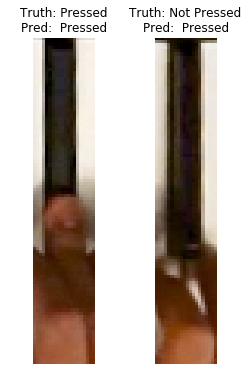

In [14]:
fig, axarr = plt.subplots(1, 2, figsize=[4, 6])
rand_idx = np.random.randint(0, 10)
i = 0
for imgb, noteb in dataset.data_batch(type='test', size='single', color='black', batch_size=2, NCHW=True, need_velocity=False):
    if i != rand_idx:
        i+=1
        continue
    yb = bmodel.evaluate(imgb)
    imgb = np.transpose(imgb, (0, 2, 3, 1))
    print(imgb.shape)
    axarr[0].imshow(cv2.cvtColor(imgb[0], cv2.COLOR_BGR2RGB))
    axarr[0].set_title('Truth: ' + visualize_keys(noteb[0]) + '\nPred:  ' + visualize_keys(yb[0]))
    axarr[0].axis('off')
    axarr[1].imshow(cv2.cvtColor(imgb[1], cv2.COLOR_BGR2RGB))
    axarr[1].set_title('Truth: ' + visualize_keys(noteb[1]) + '\nPred:  ' + visualize_keys(yb[1]))
    axarr[1].axis('off')
    break
plt.show()